In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
from datetime import datetime

# Define the assets we're interested in
assets = ['JPM', 'GS', 'MS', 'BLK', 'C']

# Define the end date for our data download
end_date = '2023-11-30'

# Download the data for each asset
data = {}
for asset in assets:
    data[asset] = yf.download(asset, end=end_date)

# Check the first few rows of one of the datasets
print(data['JPM'].head())


/Users/pranaygaurav/Downloads/Gate_Trader/virtualenvn/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/pranaygaurav/Downloads/Gate_Trader/virtualenvn/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/pranaygaurav/Downloads/Gate_Trader/virtualenvn/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timede

            Open      High       Low     Close  Adj Close  Volume
Date                                                             
1980-03-17   0.0  5.129630  5.018519  5.037037   1.083719   62775
1980-03-18   0.0  5.111111  5.037037  5.074074   1.091687   64125
1980-03-19   0.0  5.166667  5.111111  5.148148   1.107624   40500
1980-03-20   0.0  5.148148  5.092593  5.111111   1.099656   18900
1980-03-21   0.0  5.222222  5.111111  5.222222   1.123561   97200


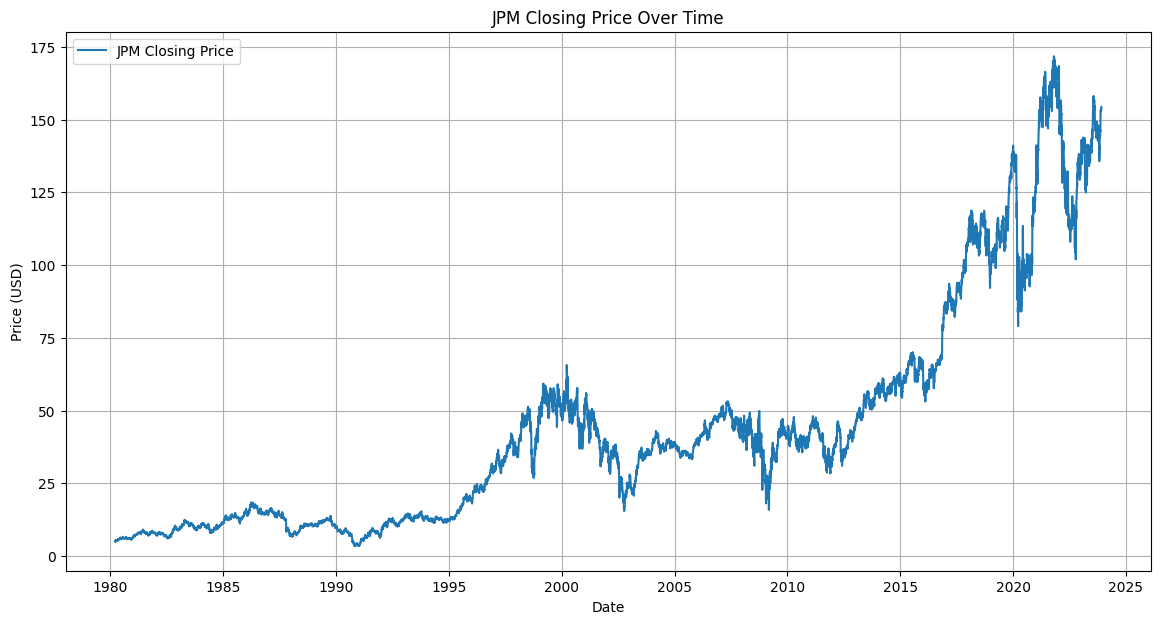

In [4]:


# Plot the closing prices of JPM
plt.figure(figsize=(14, 7))
plt.plot(data['JPM']['Close'], label='JPM Closing Price')
plt.title('JPM Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

plt.show()

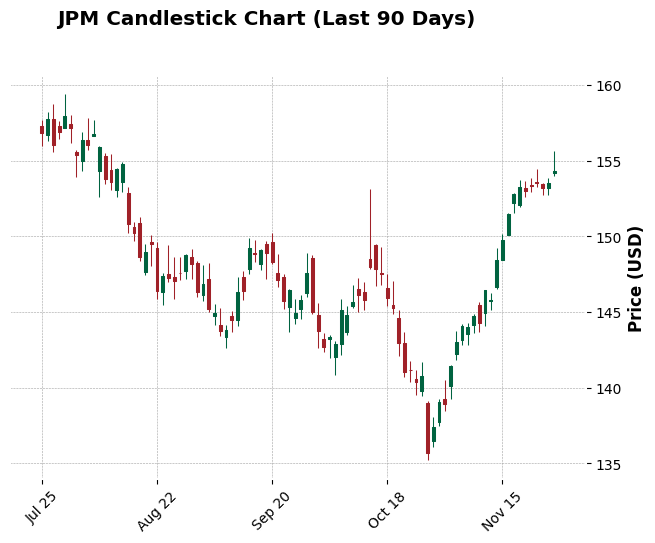

In [5]:
# Create a candlestick chart for JPM
mpf.plot(data['JPM'][-90:], type='candle', style='charles',
         title='JPM Candlestick Chart (Last 90 Days)',
         ylabel='Price (USD)')

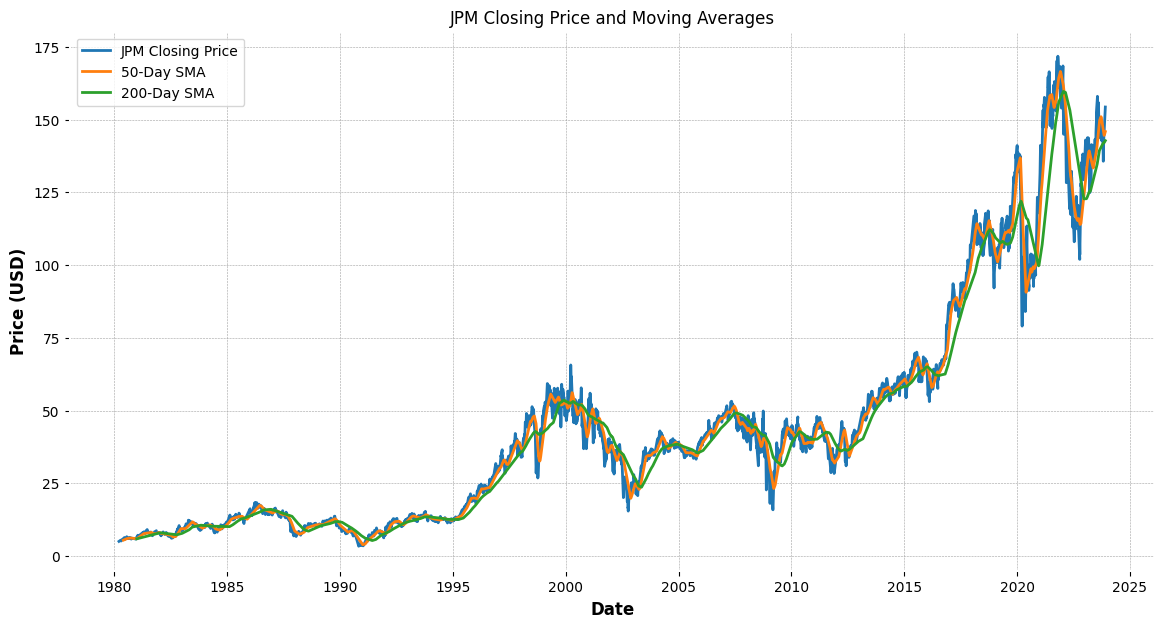

In [6]:
# Calculate the Simple Moving Average (SMA) for JPM
data['JPM']['SMA_50'] = data['JPM']['Close'].rolling(window=50).mean()
data['JPM']['SMA_200'] = data['JPM']['Close'].rolling(window=200).mean()

# Plot the SMAs along with the closing price
plt.figure(figsize=(14, 7))
plt.plot(data['JPM']['Close'], label='JPM Closing Price')
plt.plot(data['JPM']['SMA_50'], label='50-Day SMA')
plt.plot(data['JPM']['SMA_200'], label='200-Day SMA')
plt.title('JPM Closing Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

plt.show()

/var/folders/ml/b6b1w3l14w3c_10zm66ldf0w0000gn/T/ipykernel_19827/117293597.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][self.short_window:] = np.where(signals['short_mavg'][self.short_window:]


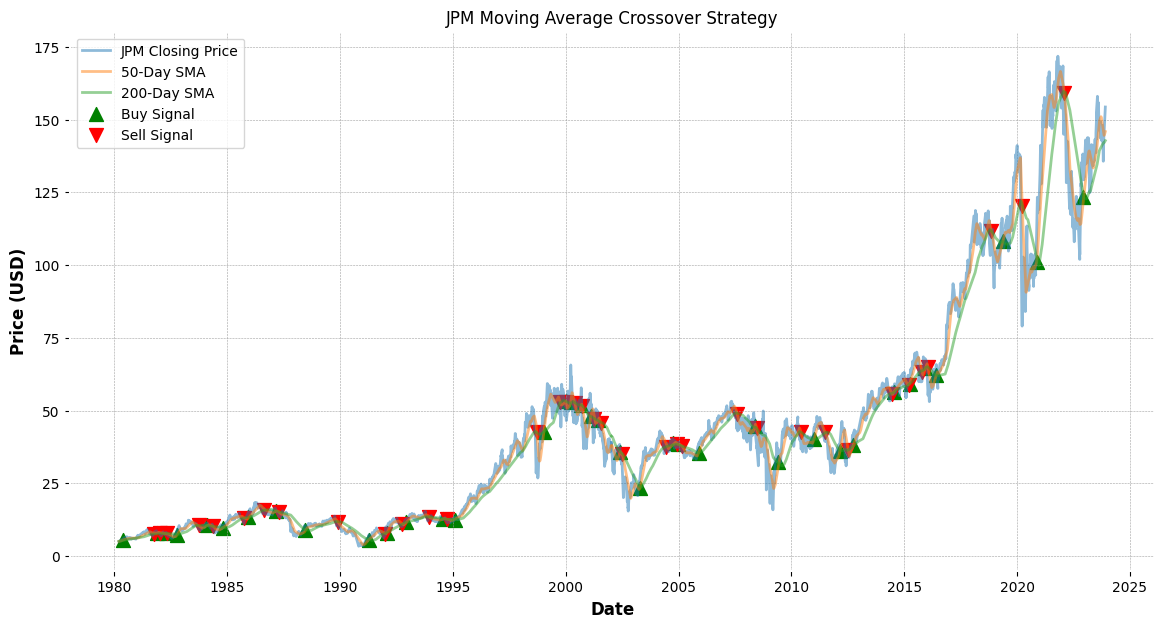

In [8]:
class MovingAverageCrossoverStrategy:
    def __init__(self, short_window, long_window):
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self, data):
        signals = pd.DataFrame(index=data.index)
        signals['signal'] = 0.0
        signals['short_mavg'] = data['Close'].rolling(window=self.short_window, min_periods=1).mean()
        signals['long_mavg'] = data['Close'].rolling(window=self.long_window, min_periods=1).mean()
        signals['signal'][self.short_window:] = np.where(signals['short_mavg'][self.short_window:] 
                                                         > signals['long_mavg'][self.short_window:], 1.0, 0.0)
        signals['positions'] = signals['signal'].diff()
        return signals

# Apply the strategy to JPM data
strategy = MovingAverageCrossoverStrategy(short_window=50, long_window=200)
signals = strategy.generate_signals(data['JPM'])

# Plot the signals along with the closing price
plt.figure(figsize=(14, 7))
plt.plot(data['JPM']['Close'], label='JPM Closing Price', alpha=0.5)
plt.plot(signals['short_mavg'], label='50-Day SMA', alpha=0.5)
plt.plot(signals['long_mavg'], label='200-Day SMA', alpha=0.5)
plt.scatter(signals.loc[signals.positions == 1.0].index, 
            signals.short_mavg[signals.positions == 1.0],
            label='Buy Signal', marker='^', color='g', s=100)
plt.scatter(signals.loc[signals.positions == -1.0].index, 
            signals.short_mavg[signals.positions == -1.0],
            label='Sell Signal', marker='v', color='r', s=100)
plt.title('JPM Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

plt.show()

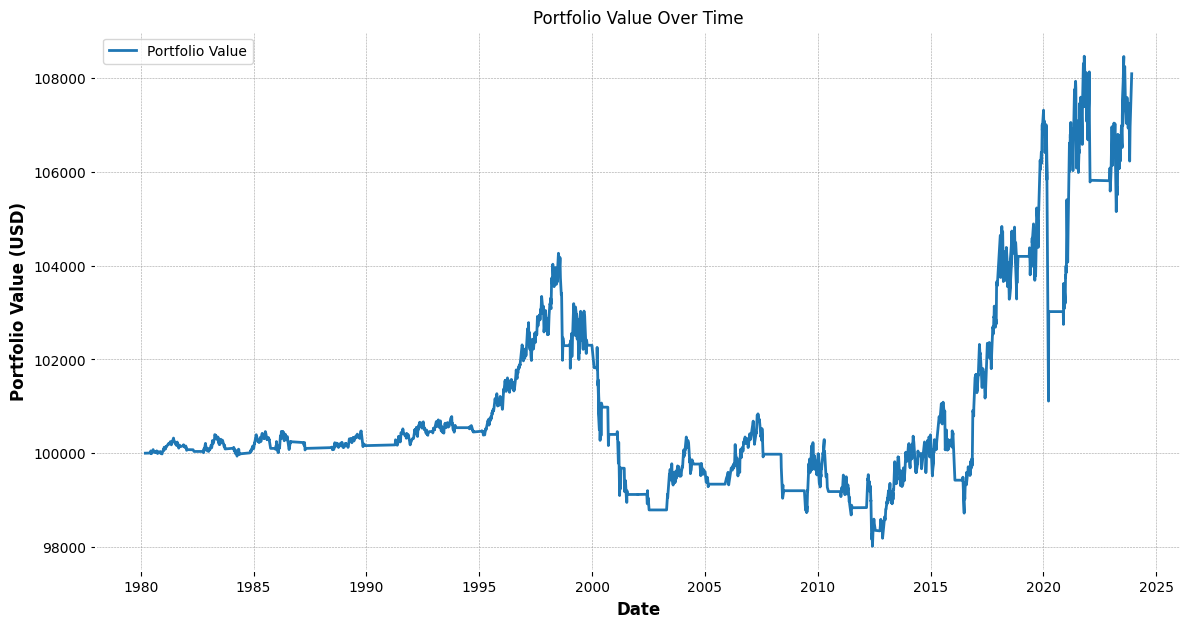

In [9]:
class Backtest:
    def __init__(self, data, signals, initial_capital=100000.0):
        self.data = data
        self.signals = signals
        self.initial_capital = initial_capital
        self.positions = self.generate_positions()
        self.portfolio = self.backtest_portfolio()

    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
        positions['JPM'] = 100 * self.signals['signal']   # This is a simple example with a fixed number of shares
        return positions

    def backtest_portfolio(self):
        portfolio = self.positions.multiply(self.data['Close'], axis=0)
        pos_diff = self.positions.diff()
        portfolio['holdings'] = (self.positions.multiply(self.data['Close'], axis=0)).sum(axis=1)
        portfolio['cash'] = self.initial_capital - (pos_diff.multiply(self.data['Close'], axis=0)).sum(axis=1).cumsum()
        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

# Backtest the strategy
backtest = Backtest(data['JPM'], signals)
portfolio = backtest.portfolio

# Plot the equity curve
plt.figure(figsize=(14, 7))
plt.plot(portfolio['total'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)

plt.show()

/var/folders/ml/b6b1w3l14w3c_10zm66ldf0w0000gn/T/ipykernel_19827/117293597.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][self.short_window:] = np.where(signals['short_mavg'][self.short_window:]


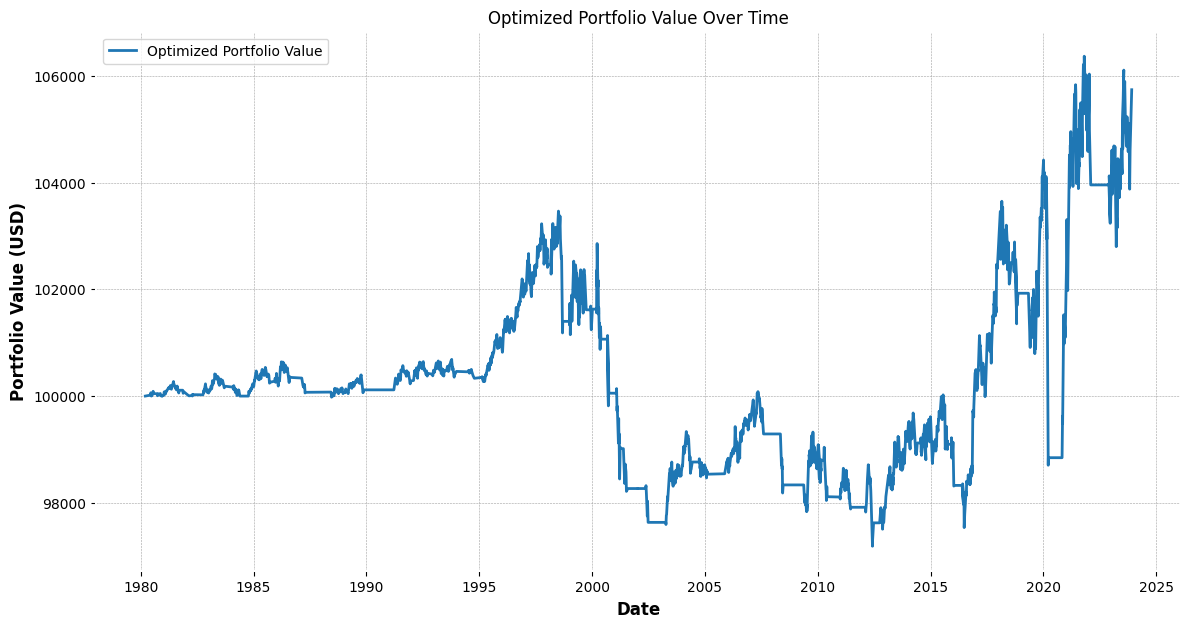

In [11]:
# Implement a simple risk management technique by limiting the maximum position size
class RiskManagedStrategy(MovingAverageCrossoverStrategy):
    def __init__(self, short_window, long_window, max_position_size):
        super().__init__(short_window, long_window)
        self.max_position_size = max_position_size

    def generate_signals(self, data):
        signals = super().generate_signals(data)
        signals['positions'] = signals['positions'].apply(lambda x: min(x, self.max_position_size))
        return signals

# Optimize the strategy by adjusting the windows and position size
optimized_strategy = RiskManagedStrategy(short_window=40, long_window=180, max_position_size=50)
optimized_signals = optimized_strategy.generate_signals(data['JPM'])

# Backtest the optimized strategy
optimized_backtest = Backtest(data['JPM'], optimized_signals)
optimized_portfolio = optimized_backtest.portfolio

# Plot the optimized equity curve
plt.figure(figsize=(14, 7))
plt.plot(optimized_portfolio['total'], label='Optimized Portfolio Value')
plt.title('Optimized Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)

plt.show()